# Looking at the transition in coherence matrix

This notebook looks into coherence matrix by running simulation of single agent in the matrix to see the change in states and states transitions.

In [1]:
import json
import pandas as pd
import numpy as np
from random import randrange
import utilities
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
import random
from random import shuffle

In [2]:
%matplotlib inline

In [3]:
# disable chained assignments
pd.options.mode.chained_assignment = None 

In [4]:
sns.set(style='whitegrid', rc={'figure.figsize':(11, 8)}, font_scale=1.5) # setting seaborn style

In [5]:
def coherence_function(k):
    """This function for generating coherence matrix """
    m = np.zeros((2**k, k))             # initialize matrix to all zeros same as Let m = matrix(len(states),numbits,0)
    numbits = [i for i in range(10)]    # this is just the temporary variable for shuffling the bits order
    for s, row in enumerate(m) :        # for s in states:  # walk through each row in the matrix
        p = random.uniform(.5,.9)       # select an initial random val
        bits = numbits[:]               # this is only for using the orderly list of 10 bits and next line shuffles every iteration
        shuffle(bits)                   # this just randomly goes through the bits
        for b in bits:
            if p < 0.01: 
                break                   # if p is close enough to zero, just stop
            m[s,b] = p                  # otherwise assign probability to the bit of that state where s is row/state and bit is column number of matrix
            p = p/2                     # for next iteration divide the probability by 2
    return m

In [6]:
# creating coherence matrix
coh_matrix = coherence_function(10)

After creating coherence matrix, we use single agent and see how it changes states over the time. However, initially we select any random state from 0, 1023 and assign some random knowledge state with combination of 1's and 0's.

In [7]:
knowledge_state_index = randrange(1024) # select a random row/state from the matrix
knowledge_state = np.random.randint(2, size=10).tolist() # we assign random value to start with

knowledge_transition = defaultdict(list) # this is to keep track of list of values

In [8]:
# for 10000 time steps we will run the through the knowledge states
for k in range(100000):
    next_state = [] # we will insert each bit of next state to list to keep track of bits flipped and it becomes current bits of state for next state
    knowledge_state_probabilities = coh_matrix[knowledge_state_index] # select the row/state we are in (which initially was randomly selected)
    
    # once we have selected the row from the matrix we look into flipping each bit knowledge space
    for i, flip_bit_probability in enumerate(knowledge_state_probabilities):
        rand_val = np.random.rand() # this is rolling a random number which we check for whether or not to flip the bit
        
        if flip_bit_probability>rand_val: # if the flipping bit probability is higher than random value we flip from 1 to 0 or 0 to 1
            next_state.append(1^knowledge_state[i]) # using XOR for 1 to 0 or 0 to 1
            
        else: # else we keep the state bit unchanged
            next_state.append(knowledge_state[i])

    # next we insert all these iteration values to defaultdict for further explorations
    knowledge_transition['Current State'].append(utilities.bool2int(knowledge_state)) # keeping track of decimal value of current state
    knowledge_transition['Current_Knowledge_State'].append(knowledge_state) # keeping raw bits of knowledge which we look for comparing number of bits flipped in each states 
    knowledge_transition['Next State'].append(utilities.bool2int(next_state)) # keeping track of decimal value of next state
    knowledge_transition['Next_Knowledge_State'].append(next_state) # keeping raw bits of knowledge which we compare with current state to look into how many bits were flipped every time
    knowledge_state_index = utilities.bool2int(next_state) # selecting next state for the walk
    
    # for next iteration knowledge state would change to next_state determined after looking into probablities
    knowledge_state = next_state

In [9]:
# creating pandas dataframe so it may be easier for plotting and others
df = pd.DataFrame(knowledge_transition).reset_index()
df.rename(columns={'index':'Time'}, inplace=True)

We looked into state transitions that is the number of times the $state_i$ $\rightarrow$ $state_j$ occurred where $i,j\in\{0, 1023\}$

In [10]:
states_df = df.groupby(['Current State', 'Next State']).size().to_frame('Count')
states_df.reset_index(inplace=True)


sorted_df = states_df.sort_values('Count', ascending=False)
print('Top 10 highest frequent state transitions are: ')
sorted_df.head(10)

Top 10 highest frequent state transitions are: 


,Current State,Next State,Count
6674,408,392,130
1851,118,119,106
4250,254,238,103
8955,557,813,99
2313,145,145,98
2323,145,657,95
3271,199,207,94
2457,152,408,93
10537,657,145,91
10316,644,640,89


In [11]:
# testing number of counts is equal to number of transitions:
sorted_df['Count'].sum() == 100000

True

Next checking how many times each bits were flipped. If there were difference in any bit flipped more than others. It is expected more or less all bits to be flipped similar number of times as it is random.

In [12]:
def bitchanges(row_val):
    """This function takes the row from the dataframe and compares the bits in current state and next states
    to check which bits flipped and which did not. The flipped bits are kept as 1 whereas, not flipped are 0 which
    later can be used with sum to check number of flipped bits."""
    
    n_bits = len(row_val['Current_Knowledge_State']) # this could be set to 10 
    bit_tracker = []                                 # keep track of the flipped bits and non-flipped bits
    for i in range(n_bits):
        if row_val['Current_Knowledge_State'][i] != row_val['Next_Knowledge_State'][i]:
            bit_tracker.append(1)                    # this means bits flipped so, append 1
        else:
            bit_tracker.append(0)                    # if bit did not flipped in next state append 0
    return np.array(bit_tracker)

In [13]:
df['tracker'] = df.apply(lambda row : bitchanges(row), axis=1)
flipped_df = pd.DataFrame({'bit{}'.format(i):sum(df['tracker'].str[i]) for i in range(10)}, index=[0]).T
flipped_df.columns = ['Number of times bit was flipped']

Plotting bar graph for comparing number of times each bits were flipped.

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9
Number of times bit was flipped,13004,13916,13808,13840,13711,13195,13798,13829,14225,13399


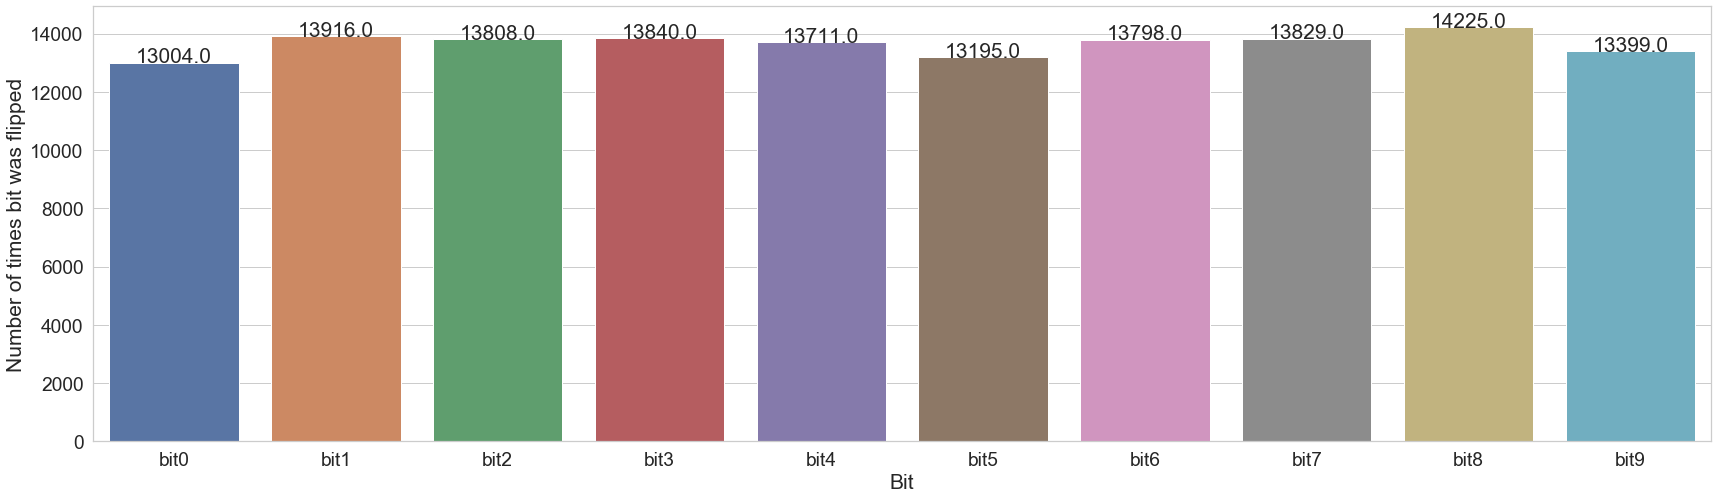

In [14]:
display(flipped_df.T)
sns.set(style='whitegrid', rc={'figure.figsize':(29, 8)}, font_scale=1.75) # setting seaborn style

flip_bit_df = flipped_df.reset_index().rename(columns={'index':'Bit'})
bar_graph = sns.barplot(x='Bit', y='Number of times bit was flipped', data=flip_bit_df)
for p in bar_graph.patches:
        height = p.get_height()
        bar_graph.text(p.get_x()+p.get_width()/2., height + 0.009,height ,ha="center")

In [15]:
flip_bit_df['Number of times bit was flipped'].sum()

136725

As total number of flip bits were 136725. It is possible that sometimes more than one bit is flipped whereas, sometimes none bits were flipped i.e. stayed in same state. As below shows that on average and median the number of bits flipped were 1.

In [16]:
df['flipped_bits_count'] = df['tracker'].apply(lambda row: row.sum())
pd.DataFrame(df['flipped_bits_count'].describe()).T

,count,mean,std,min,25%,50%,75%,max
flipped_bits_count,100000.0,1.36725,0.875571,0.0,1.0,1.0,2.0,6.0


Looking into heatmap for the current state and next state

In [17]:
table = pd.crosstab(df['Current State'], df['Next State'])

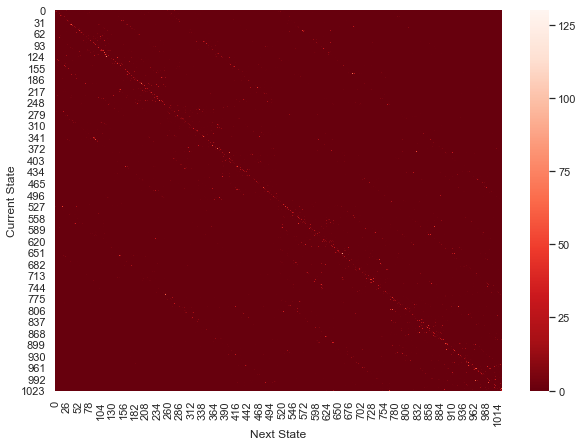

In [18]:
sns.set(rc={'figure.figsize':(10,7)})
sns.heatmap(table, cmap='Reds_r');

Checking if any of the state was mostly occurred irrespective of last state looking at top 30 states that occured.

In [20]:
df.groupby('Current State').size().to_frame('Count').sort_values('Count', ascending=False).head(30)

,Count
Current State,
408,381
254,349
145,336
152,336
118,307
657,303
144,299
644,298
199,274


Checking if attractor is possible with larger number of t values

In [21]:
knowledge_state_index = randrange(1024) # select a random row/state from the matrix
knowledge_state = np.random.randint(2, size=10).tolist() # we assign random value to start with

knowledge_transition = defaultdict(list) # this is to keep track of list of values

time_state_occurences = defaultdict(list)

In [22]:
knowledge_state = np.random.randint(2, size=10).tolist() # we assign random value to start with

knowledge_transition = defaultdict(list) # this is to keep track of list of values
# for 10000 time steps we will run the through the knowledge states
for k in range(300000):
    next_state = [] # we will insert each bit of next state to list to keep track of bits flipped and it becomes current bits of state for next state
    knowledge_state_probabilities = coh_matrix[knowledge_state_index] # select the row/state we are in (which initially was randomly selected)
    
    # once we have selected the row from the matrix we look into flipping each bit knowledge space
    for i, flip_bit_probability in enumerate(knowledge_state_probabilities):
        rand_val = np.random.rand() # this is rolling a random number which we check for whether or not to flip the bit
        
        if flip_bit_probability>rand_val: # if the flipping bit probability is higher than random value we flip from 1 to 0 or 0 to 1
            next_state.append(1^knowledge_state[i]) # using XOR for 1 to 0 or 0 to 1
            
        else: # else we keep the state bit unchanged
            next_state.append(knowledge_state[i])

    # next we insert all these iteration values to defaultdict for further explorations
    knowledge_transition['Current State'].append(utilities.bool2int(knowledge_state)) # keeping track of decimal value of current state
    knowledge_transition['Current_Knowledge_State'].append(knowledge_state) # keeping raw bits of knowledge which we look for comparing number of bits flipped in each states 
    knowledge_transition['Next State'].append(utilities.bool2int(next_state)) # keeping track of decimal value of next state
    knowledge_transition['Next_Knowledge_State'].append(next_state) # keeping raw bits of knowledge which we compare with current state to look into how many bits were flipped every time
    knowledge_state_index = utilities.bool2int(next_state) # selecting next state for the walk
    
    # for next iteration knowledge state would change to next_state determined after looking into probablities
    knowledge_state = next_state
    if k>0 and k % 10000 ==0:
        # creating pandas dataframe so it may be easier for plotting and others
        df = pd.DataFrame(knowledge_transition).reset_index()
        df.rename(columns={'index':'Time'}, inplace=True)
        x = df.groupby('Current State').size().to_frame('Count').sort_values('Count', ascending=False)
        top_state = x.head(1).index[0]
        top_state_occurence = x.head(1)['Count'].values[0]
        time_state_occurences['iterations'].append(k)
        time_state_occurences['top_occured_state'].append(top_state)
        time_state_occurences['top_occured_state_frq'].append(top_state_occurence)

In [23]:
tmp = pd.DataFrame(time_state_occurences)
# tmp
tmp['(occurence/num of iterations)%'] = tmp['top_occured_state_frq']/tmp['iterations']*100

In [24]:
tmp

,iterations,top_occured_state,top_occured_state_frq,(occurence/num of iterations)%
0,10000,408,44,0.440000
1,20000,408,87,0.435000
2,30000,408,119,0.396667
3,40000,254,164,0.410000
4,50000,254,199,0.398000
5,60000,254,248,0.413333
6,70000,408,302,0.431429
7,80000,408,357,0.446250
8,90000,408,414,0.460000
9,100000,408,452,0.452000


While the top occuring state is stable but it the proportion does not changes much as time increases.